In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('AMZN_stock_data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6987 entries, 0 to 6986
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          6987 non-null   object 
 1   Open          6987 non-null   float64
 2   High          6987 non-null   float64
 3   Low           6987 non-null   float64
 4   Close         6987 non-null   float64
 5   Volume        6987 non-null   int64  
 6   Dividends     6987 non-null   float64
 7   Stock Splits  6987 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 436.8+ KB


In [ ]:
data.head(2).T

,0,1
Date,1997-05-15 00:00:00-04:00,1997-05-16 00:00:00-04:00
Open,0.121875,0.098438
High,0.125,0.098958
Low,0.096354,0.085417
Close,0.097917,0.086458
Volume,1443120000,294000000
Dividends,0.0,0.0
Stock Splits,0.0,0.0


In [4]:
data.index = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S%z')

<ipython-input-4-8c4fba35574a>:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data.index = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S%z')


In [5]:
data.head(2).T

Date,1997-05-15 00:00:00-04:00,1997-05-16 00:00:00-04:00
Date,1997-05-15 00:00:00-04:00,1997-05-16 00:00:00-04:00
Open,0.121875,0.098438
High,0.125,0.098958
Low,0.096354,0.085417
Close,0.097917,0.086458
Volume,1443120000,294000000
Dividends,0.0,0.0
Stock Splits,0.0,0.0


In [6]:
close = data['Close']

In [ ]:
close.head()

,Close
Date,
1997-05-15 00:00:00-04:00,0.097917
1997-05-16 00:00:00-04:00,0.086458
1997-05-19 00:00:00-04:00,0.085417
1997-05-20 00:00:00-04:00,0.081771
1997-05-21 00:00:00-04:00,0.071354


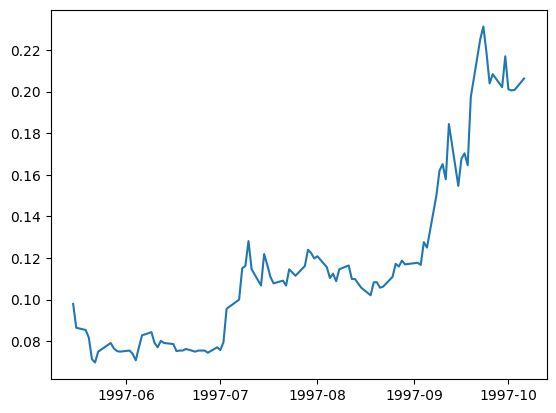

In [7]:
plt.plot(close[:100])
plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close.to_numpy().reshape(-1, 1)).flatten()

In [9]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [13]:
WINDOW_SIZE = 60
X1, y1 = df_to_X_y(pd.Series(scaled_close), WINDOW_SIZE)
X1.shape, y1.shape

((6927, 60, 1), (6927,))

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [16]:
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [17]:
x_train.shape, x_validation.shape, x_test.shape

((5541, 60, 1), (693, 60, 1), (693, 60, 1))

In [18]:
y_train.shape, y_validation.shape, y_test.shape

((5541,), (693,), (693,))

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  LSTM, Dense, Dropout,Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
def My_model(window_size,par_num,lstm_units1,lstm_units2,Dense1,Dense2):
    input_layer = Input(shape=(window_size,par_num))
    lstm_layer = LSTM(units=lstm_units1, return_sequences=True)(input_layer)
    lstm_layer_2 = LSTM(units=lstm_units2)(lstm_layer)
    dense1 = Dense(units=Dense1, activation='relu')(lstm_layer_2)
    output_layer = Dense(units=Dense2, activation='linear')(dense1)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
model2 = My_model(WINDOW_SIZE,1,32,64,8,1)

In [ ]:
model2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,713 (116.07 KB)

 Trainable params: 29,713 (116.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp1 = ModelCheckpoint('model2.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
history = model2.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=50, callbacks=[cp1])

Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - loss: 0.0258 - root_mean_squared_error: 0.1525 - val_loss: 2.2336e-04 - val_root_mean_squared_error: 0.0149
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - loss: 3.2926e-04 - root_mean_squared_error: 0.0181 - val_loss: 2.1220e-04 - val_root_mean_squared_error: 0.0146
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 2.8704e-04 - root_mean_squared_error: 0.0169 - val_loss: 2.1337e-04 - val_root_mean_squared_error: 0.0146
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 2.8833e-04 - root_mean_squared_error: 0.0170 - val_loss: 1.7696e-04 - val_root_mean_squared_error: 0.0133
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 2.6834e-04 - root_mean_squared_error: 0.0164 - val_loss: 1.7094e-04 - val_root_mean_squared_error: 0.0131
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 2.5312e-04 - root_mean_squared_error: 0.0159 - val_loss: 1.9398e-04 - val_root_mean_squared_error: 0.01

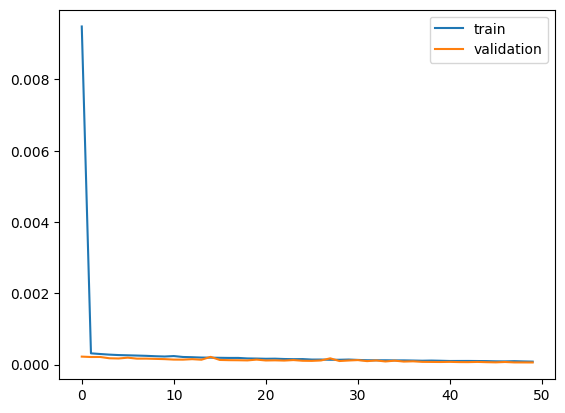

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

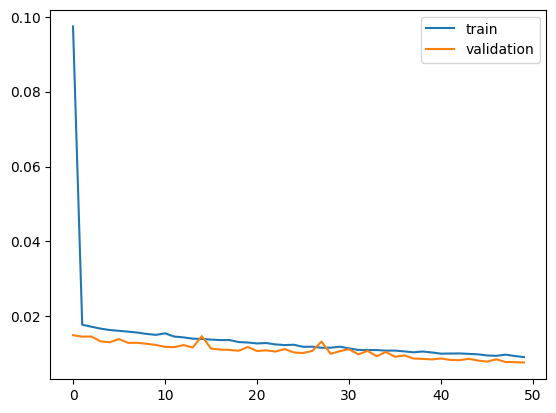

In [ ]:
plt.plot(history.history['root_mean_squared_error'], label='train')
plt.plot(history.history['val_root_mean_squared_error'], label='validation')
plt.legend()
plt.show()

In [ ]:
train_predictions = model2.predict(x_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


,Train Predictions,Actuals
0,0.160346,0.160952
1,0.024222,0.023851
2,0.065942,0.064063
3,0.005600,0.006251
4,0.053775,0.056142
...,...,...
5536,0.046537,0.048059
5537,0.319997,0.295471
5538,0.332023,0.326535
5539,0.339696,0.338684


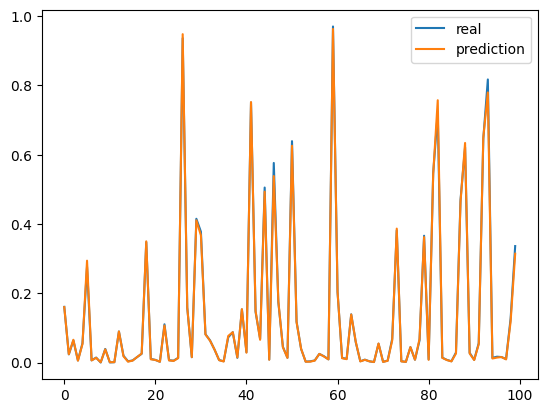

In [ ]:
plt.plot(y_train[:100], label='real')
plt.plot(train_predictions[:100], label='prediction')
plt.legend()
plt.show()

In [ ]:
validation_predictions = model2.predict(x_validation).flatten()
validation_results = pd.DataFrame(data={'validation Predictions':validation_predictions, 'Actuals':y_validation})
validation_results

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


,validation Predictions,Actuals
0,0.024778,0.024161
1,0.006389,0.006751
2,0.621214,0.646223
3,0.007146,0.007863
4,0.006345,0.006220
...,...,...
688,0.246085,0.239876
689,0.209216,0.208412
690,0.720684,0.724005
691,0.949446,0.945907


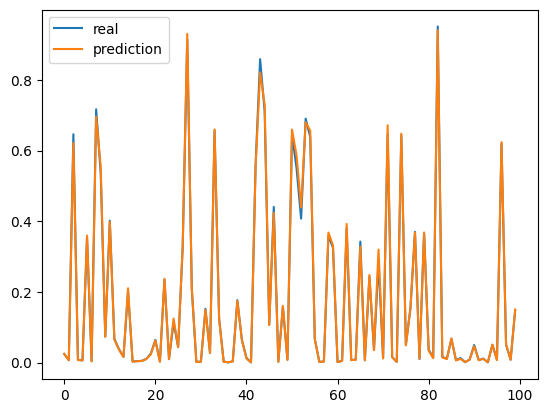

In [ ]:
plt.plot(y_validation[:100], label='real')
plt.plot(validation_predictions[:100], label='prediction')
plt.legend()
plt.show()

In [ ]:
test_predictions = model2.predict(x_test).flatten()
test_results = pd.DataFrame(data={'test Predictions':test_predictions, 'Actuals':y_test})
test_results

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


,test Predictions,Actuals
0,0.054001,0.053805
1,0.658948,0.657920
2,0.007739,0.008474
3,0.013268,0.013103
4,0.026014,0.028461
...,...,...
688,0.348234,0.335665
689,0.133953,0.132434
690,0.661174,0.663170
691,0.047757,0.048222


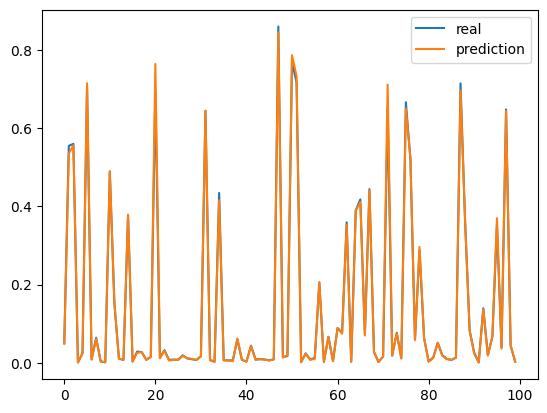

In [ ]:
plt.plot(y_test[100:200], label='real')
plt.plot(test_predictions[100:200], label='prediction')
plt.legend()
plt.show()

In [ ]:
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
test_predictions_actual = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

In [ ]:
test_results = pd.DataFrame(data={'test Predictions':test_predictions_actual, 'Actuals':y_test_actual})

In [ ]:
test_results

,test Predictions,Actuals
0,13.137490,13.090000
1,159.528763,159.279999
2,1.942457,2.120500
3,3.280463,3.240625
4,6.364939,6.957000
...,...,...
688,84.339012,81.297501
689,32.485058,32.117500
690,160.067307,160.550507
691,11.626568,11.739000


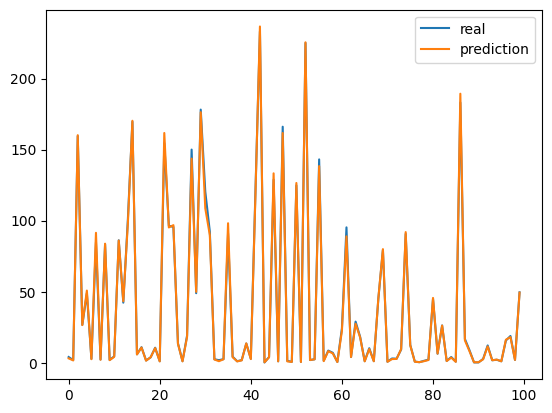

In [ ]:
plt.plot(y_test_actual[500:600], label='real')
plt.plot(test_predictions_actual[400:500], label='prediction')
plt.legend()
plt.show()